##  RFM Analysis

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('sample-orders.csv')

In [3]:
df.head()

,order_date,order_id,customer,grand_total
0,1/1/14 0:00,US-1,Mychal Olson DDS,65
1,1/1/14 0:00,US-2,Ms. Marybeth Breitenberg,68
2,1/1/14 0:00,US-3,Devin Lynch,50
3,1/1/14 0:00,US-4,Allene Nitzsche,76
4,1/1/14 0:00,US-5,Reynaldo Jewess,20


In [4]:
# creating column for order date format: 
df['order_date_only'] = pd.to_datetime(df['order_date'])

In [5]:
df = df.drop(['order_date'], axis = 1)

In [6]:
df.head()

,order_id,customer,grand_total,order_date_only
0,US-1,Mychal Olson DDS,65,2014-01-01
1,US-2,Ms. Marybeth Breitenberg,68,2014-01-01
2,US-3,Devin Lynch,50,2014-01-01
3,US-4,Allene Nitzsche,76,2014-01-01
4,US-5,Reynaldo Jewess,20,2014-01-01


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25613 entries, 0 to 25612
Data columns (total 4 columns):
order_id           25613 non-null object
customer           25613 non-null object
grand_total        25613 non-null int64
order_date_only    25613 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 800.5+ KB


In [26]:
len(pd.unique(df.customer)) #Unique customers

13787

In [28]:
min(df.order_date_only), max(df.order_date_only) # orders range:

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-03-31 23:25:00'))

### Calculating the R, F, and M values: (Note: considering today as 01-04-2014)

In [7]:
import datetime
today = datetime.datetime(2014,4,1)

In [8]:
rfm = df.groupby('customer').agg({'order_date_only': lambda x: int((today - x.max()).days),'order_id': lambda x: len(x), 'grand_total': lambda x: x.sum()})

In [9]:
rfm.rename(columns={'order_date_only': 'recency','order_id': 'frequency','grand_total': 'monetary'},inplace=True)

In [10]:
rfm.head()

,recency,frequency,monetary
customer,,,
Aaliyah Carroll,4,1,31
Aaliyah Padberg,21,1,76
Aarav Hyatt,43,1,40
Aarav Kassulke,70,1,38
Aarav Kutch,72,1,26


###  Dividing the RFM into 5 parts i.e., quintiles

In [11]:
q = rfm.quantile(q=[0.2,0.4,0.6,0.8]).to_dict()

In [12]:
q

{'recency': {0.2: 10.0, 0.4: 26.0, 0.6: 45.0, 0.8: 67.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 2.0},
 'monetary': {0.2: 39.0, 0.4: 58.0, 0.6: 75.0, 0.8: 123.0}}

We need toto assign ranks from 1 to 5. A smaller Recency value is better whereas higher Frequency 
and Monetary values are better. So, writing two separate methods.

In [13]:
def r_score(x):
    if x <= q['recency'][0.2]:
        return 5
    elif x <= q['recency'][0.4]:
        return 4
    elif x <= q['recency'][0.6]:
        return 3
    elif x <= q['recency'][0.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= q[c][0.2]:
        return 1
    elif x <= q[c][0.4]:
        return 2
    elif x <= q[c][0.6]:
        return 3
    elif x <= q[c][0.8]:
        return 4
    else:
        return 5 

In [14]:
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: fm_score(x, 'frequency'))
rfm['M'] = rfm['monetary'].apply(lambda x: fm_score(x, 'monetary'))

In [15]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

In [16]:
rfm.head()

,recency,frequency,monetary,R,F,M,RFM Score
customer,,,,,,,
Aaliyah Carroll,4,1,31,5,1,1,511
Aaliyah Padberg,21,1,76,4,1,4,414
Aarav Hyatt,43,1,40,3,1,2,312
Aarav Kassulke,70,1,38,1,1,1,111
Aarav Kutch,72,1,26,1,1,1,111


In [17]:
#saving it to a CSV file.
rfm.to_clipboard()
rfm.to_csv('rfm-table.csv', sep=',')

Who are the top 5 best customers? by RFM Class (111), buy often and spend the most with recent transaction?

In [18]:
rfm[rfm['RFM Score']=='111'].sort_values('monetary', ascending=False).head(5)

,recency,frequency,monetary,R,F,M,RFM Score
customer,,,,,,,
Brenna Boehm,88,1,39,1,1,1,111
Emory Koepp,81,1,39,1,1,1,111
Odis Schoen,88,1,39,1,1,1,111
Noelle Turcotte,80,1,39,1,1,1,111
Nile Wiegand,84,1,39,1,1,1,111


#### The RFM scores give us 5^^3 = 125 segments which is not easy to work with. So dividing 10 segments based on the R and F scores. 

#### The segments are:
    Champions
    Loyal Customers
    Potential Loyalist
    Recent Customers
    Promising
    Customers Needing Attention
    About To Sleep
    At Risk
    Can’t Lose Them
    Hibernating

In [19]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

In [20]:
rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,recency,frequency,monetary,R,F,M,RFM Score,Segment
customer,,,,,,,,
Aaliyah Carroll,4,1,31,5,1,1,511,new customers
Aaliyah Padberg,21,1,76,4,1,4,414,promising
Aarav Hyatt,43,1,40,3,1,2,312,about to sleep
Aarav Kassulke,70,1,38,1,1,1,111,hibernating
Aarav Kutch,72,1,26,1,1,1,111,hibernating


### Visualization of RFM:

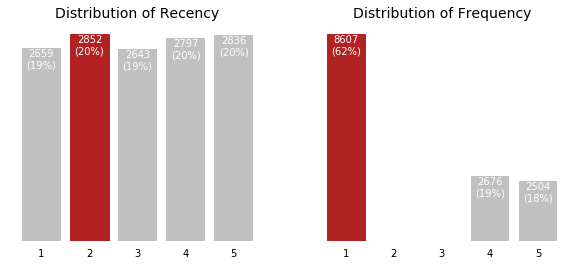

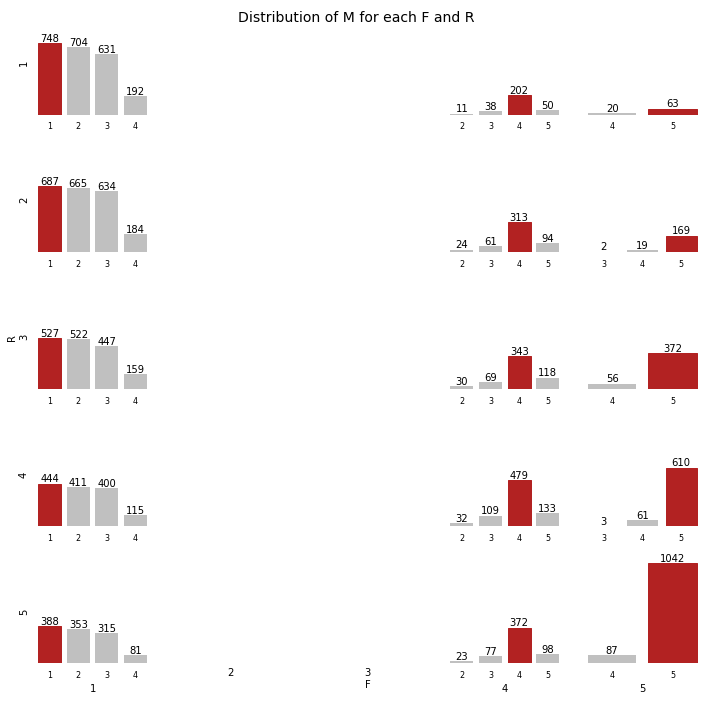

In [22]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')
        
plt.show()

# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

When looking at the monetary value, we see that the customers spending the most are those with the highest activity (R and F of 4-5).

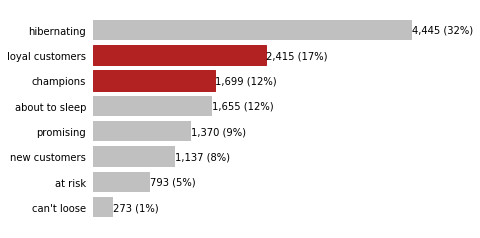

In [29]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

We have a lot of customers who don't buy frequently from us (32% are hibernating). 
However, 29% of our customers are either champions or loyal customers.